<a href="https://colab.research.google.com/github/popkaotarbuza/sleep-disorder-diagnosis/blob/dev/ABC-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
github_csv_url = 'https://raw.githubusercontent.com/popkaotarbuza/sleep-disorder-diagnosis/refs/heads/dev/src/data/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(github_csv_url)

In [44]:
# Получаем все профессии
all_occupations = df['Occupation'].unique()

# Приводим все Series к одному индексу (чтобы корректно суммировались счетчики людей с расстройством сна)
with_sleep_apnea = df[df['Sleep Disorder'] == 'Sleep Apnea'].groupby('Occupation').size().reindex(all_occupations, fill_value=0)
with_insomnia    = df[df['Sleep Disorder'] == 'Insomnia'].groupby('Occupation').size().reindex(all_occupations, fill_value=0)
total            = df.groupby('Occupation').size().reindex(all_occupations, fill_value=0)

# Создаём таблицу датафрейма
disorder_detail = pd.DataFrame({
    'Всего человек': total,
    'Апноэ сна': with_sleep_apnea,
    'Бессонница': with_insomnia,
    'Без расстройств': total - (with_sleep_apnea + with_insomnia)
})

# Добавляем метрики
disorder_detail['С расстройством сна'] = disorder_detail['Апноэ сна'] + disorder_detail['Бессонница']
disorder_detail['% с расстройством'] = (disorder_detail['С расстройством сна'] / disorder_detail['Всего человек'] * 100).round(1)

# Сортируем по убыванию больных
disorder_detail = disorder_detail.sort_values('С расстройством сна', ascending=False)

# ABC-анализ
total_cases = disorder_detail['С расстройством сна'].sum()
disorder_detail['Доля от всех случаев, %'] = (disorder_detail['С расстройством сна'] / total_cases * 100).round(20)
disorder_detail['Накопительная доля, %'] = disorder_detail['Доля от всех случаев, %'].cumsum()

#A - высокая группа риска
#B - средняя группа риска
#C - низкая группа риска
def abc_group(cum):
    if cum <= 80:
        return 'A'
    elif cum <= 95:
        return 'B'
    else:
        return 'C'

disorder_detail['ABC-группа'] = disorder_detail['Накопительная доля, %'].apply(abc_group)

# Сбрасываем индекс — теперь колонка с профессией называется 'Occupation'
disorder_detail = disorder_detail.reset_index()

# Переименовываем колонку в "Профессия"
disorder_detail = disorder_detail.rename(columns={'Occupation': 'Профессия'})

# Финальная таблица
final = disorder_detail[[
    'Профессия', 'Всего человек', 'Апноэ сна', 'Бессонница', 'Без расстройств',
    'С расстройством сна', '% с расстройством', 'Накопительная доля, %', 'ABC-группа'
]]
print(final.to_string(index=False))

           Профессия  Всего человек  Апноэ сна  Бессонница  Без расстройств  С расстройством сна  % с расстройством  Накопительная доля, % ABC-группа
               Nurse             73         61           3                9                   64               87.7              41.290323          A
             Teacher             40          4          27                9                   31               77.5              61.290323          A
         Salesperson             32          1          29                2                   30               93.8              80.645161          B
              Doctor             71          4           3               64                    7                9.9              85.161290          B
          Accountant             37          0           7               30                    7               18.9              89.677419          B
            Engineer             63          1           5               57                    6    

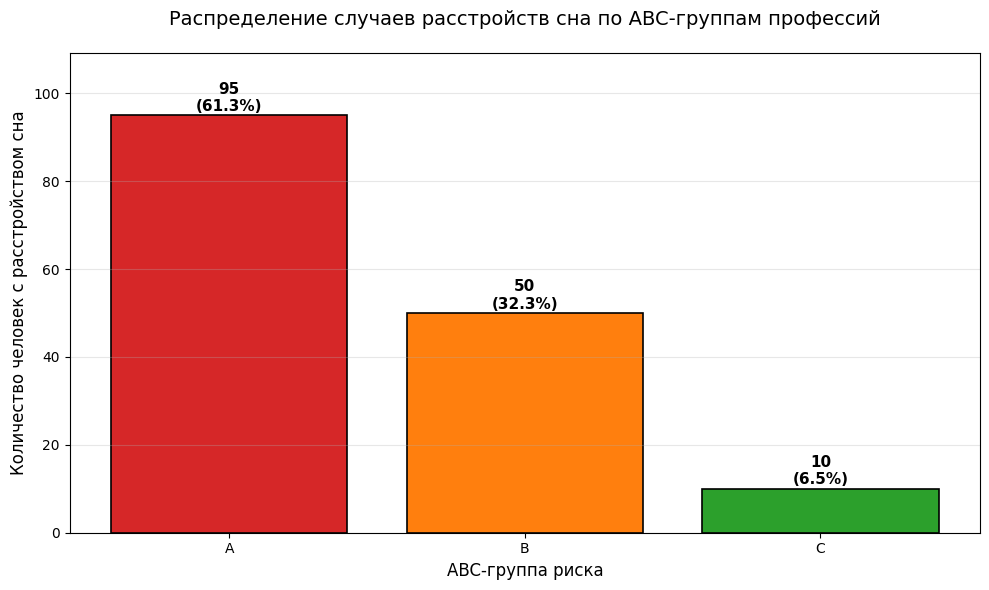

In [49]:
# Добавляем гистограмму после таблицы
plt.figure(figsize=(10, 6))

# Считаем количество человек с расстройством сна по ABC-группам
abc_summary = final.groupby('ABC-группа').agg({
    'С расстройством сна': 'sum',
    'Всего человек': 'sum'
}).reset_index()

# Сортируем группы в правильном порядке A -> B -> C
abc_summary['ABC-группа'] = pd.Categorical(abc_summary['ABC-группа'], categories=['A', 'B', 'C'], ordered=True)
abc_summary = abc_summary.sort_values('ABC-группа')

# Палитра: красный — A, оранжевый — B, зелёный — C
colors = {'A': '#d62728', 'B': '#ff7f0e', 'C': '#2ca02c'}

plt.bar(abc_summary['ABC-группа'],
        abc_summary['С расстройством сна'],
        color=[colors[x] for x in abc_summary['ABC-группа']],
        edgecolor='black', linewidth=1.2)

plt.title('Распределение случаев расстройств сна по ABC-группам профессий', fontsize=14, pad=20)
plt.xlabel('ABC-группа риска', fontsize=12)
plt.ylabel('Количество человек с расстройством сна', fontsize=12)

# Подписи значений над столбцами
for i, row in abc_summary.iterrows():
    plt.text(row.name, row['С расстройством сна'] + 1,
             f"{int(row['С расстройством сна'])}\n({row['С расстройством сна']/total_cases*100:.1f}%)",
             ha='center', fontsize=11, fontweight='bold')

plt.ylim(0, abc_summary['С расстройством сна'].max() * 1.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()